# Statistical Algos

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

TARGET_FUT, INTERVAL

('ZC', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(1938, 128)
Index(['10Y_Open', '10Y_High', '10Y_Low', '10Y_Close', '10Y_Volume',
       '10Y_Barcount', '10Y_Average', '10Y_Spread', '2YY_Open', '2YY_High',
       ...
       'ZS_Average', 'ZS_Spread', 'ZW_Open', 'ZW_High', 'ZW_Low', 'ZW_Close',
       'ZW_Volume', 'ZW_Barcount', 'ZW_Average', 'ZW_Spread'],
      dtype='object', length=128)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2YY_Open,2YY_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29 15:30:00+00:00,3.883,3.883,3.86,3.860,95.0,48.0,3.8709,0.023,4.184,4.184,...,1308.375,5.0,630.25,632.00,626.25,629.50,3081.0,1133.0,628.7,5.75
2023-12-29 15:45:00+00:00,3.860,3.878,3.86,3.875,18.0,14.0,3.8722,0.018,4.184,4.184,...,1304.325,3.5,629.75,631.25,628.75,629.25,996.0,468.0,630.1,2.50


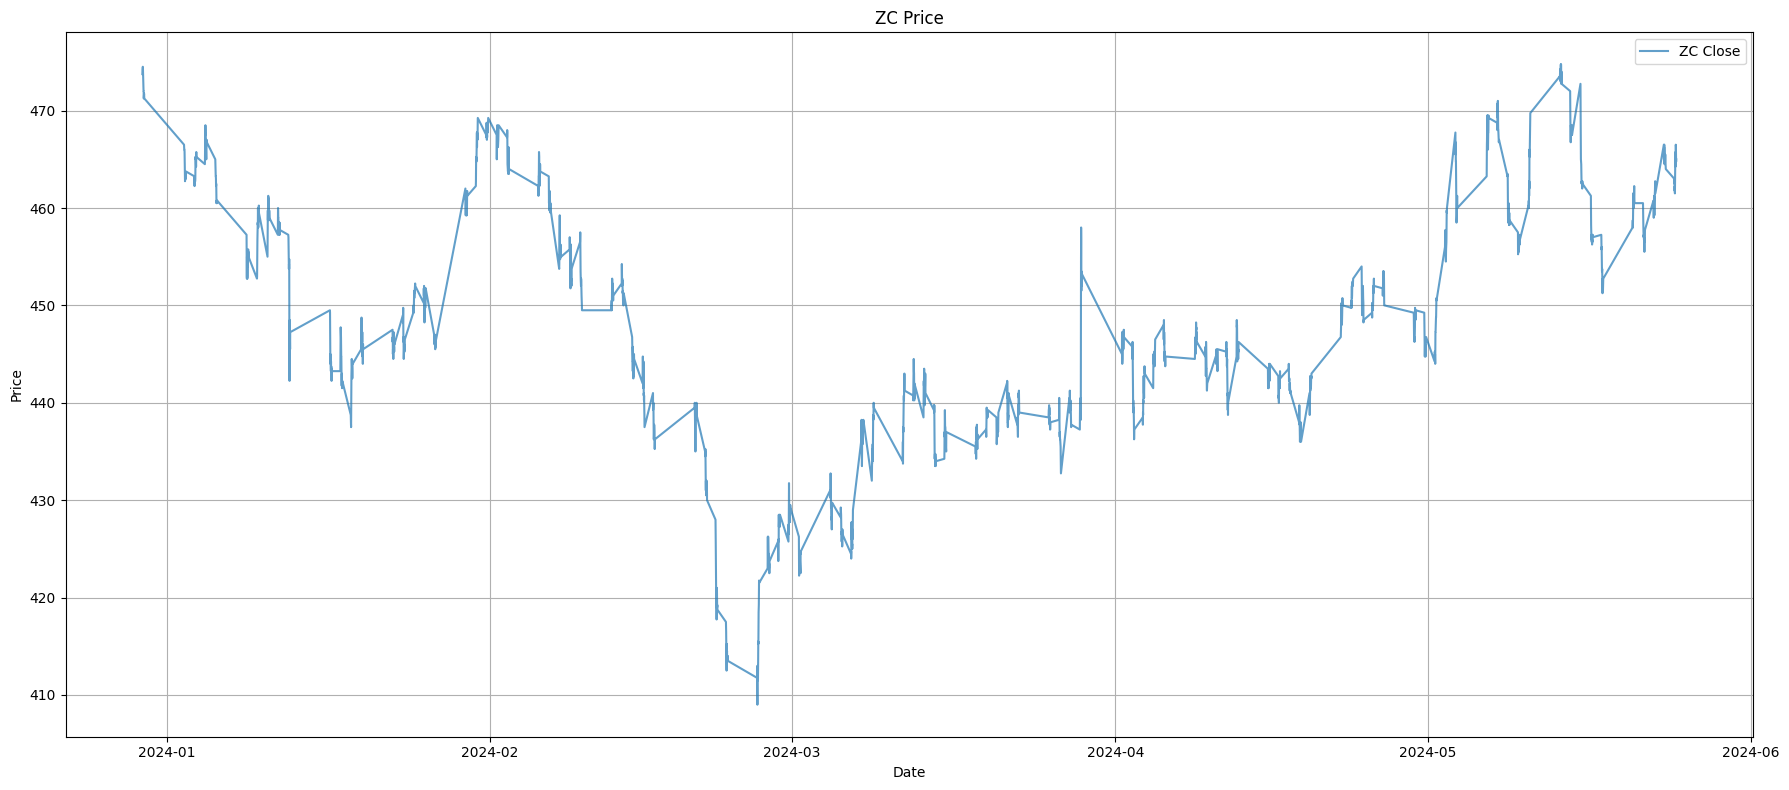

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Problem Defintion

Utilize meduim-frequency trade data for a set of 6 Future contracts listed on CME during a 250-day trading periods between 01/01/2023 and 01/01/2024. Future contracts are cross-sectional from metals, equities and volatiliyy. Trading is 23hours, with minute durations.

In [6]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close"]]

# Support and Resistance with Clustering

https://www.researchgate.net/publication/255993239_The_Bollinger_lines_and_pivot_points_-_methods_of_making_the_best_decision_in_the_stock_exchange

In [7]:
from quant_equations import get_ou

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")
HALF_LIFE, HURST

(135, 0.5093391169683746)

In [9]:
from tqdm import tqdm
from signals import dynamic_support_resistance

sr_df, dynamic_support, dynamic_resistance = dynamic_support_resistance(futs_df, f"{TARGET_FUT}_Close", f"{TARGET_FUT}_High",f"{TARGET_FUT}_Low")
sr_df.tail(5)

,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2YY_Open,2YY_High,...,ZW_Barcount,ZW_Average,ZW_Spread,PP,S1,R1,S2,R2,Support,Resistance
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-24 19:00:00+00:00,4.467,4.468,4.465,4.465,29.0,9.0,4.4661,0.003,4.920,4.920,...,811.0,702.65,7.75,465.916667,465.333333,467.083333,464.166667,467.666667,462.45584,465.158693
2024-05-24 19:15:00+00:00,4.465,4.465,4.459,4.462,92.0,20.0,4.4626,0.006,4.915,4.915,...,822.0,703.55,4.75,466.333333,465.916667,466.666667,465.583333,467.083333,462.45584,465.158693
2024-05-24 19:30:00+00:00,4.463,4.464,4.461,4.463,153.0,21.0,4.4627,0.003,4.915,4.915,...,822.0,697.70,7.50,465.500000,465.000000,466.000000,464.500000,466.500000,462.45584,465.158693
2024-05-24 19:45:00+00:00,4.463,4.463,4.460,4.463,30.0,17.0,4.4621,0.003,4.915,4.915,...,925.0,695.75,5.50,465.000000,464.250000,465.500000,463.750000,466.250000,462.45584,465.158693
2024-05-24 20:00:00+00:00,4.463,4.463,4.458,4.458,47.0,16.0,4.4606,0.005,4.915,4.915,...,1452.0,696.90,3.25,464.666667,464.333333,465.333333,463.666667,465.666667,462.45584,465.158693


## Visual Results

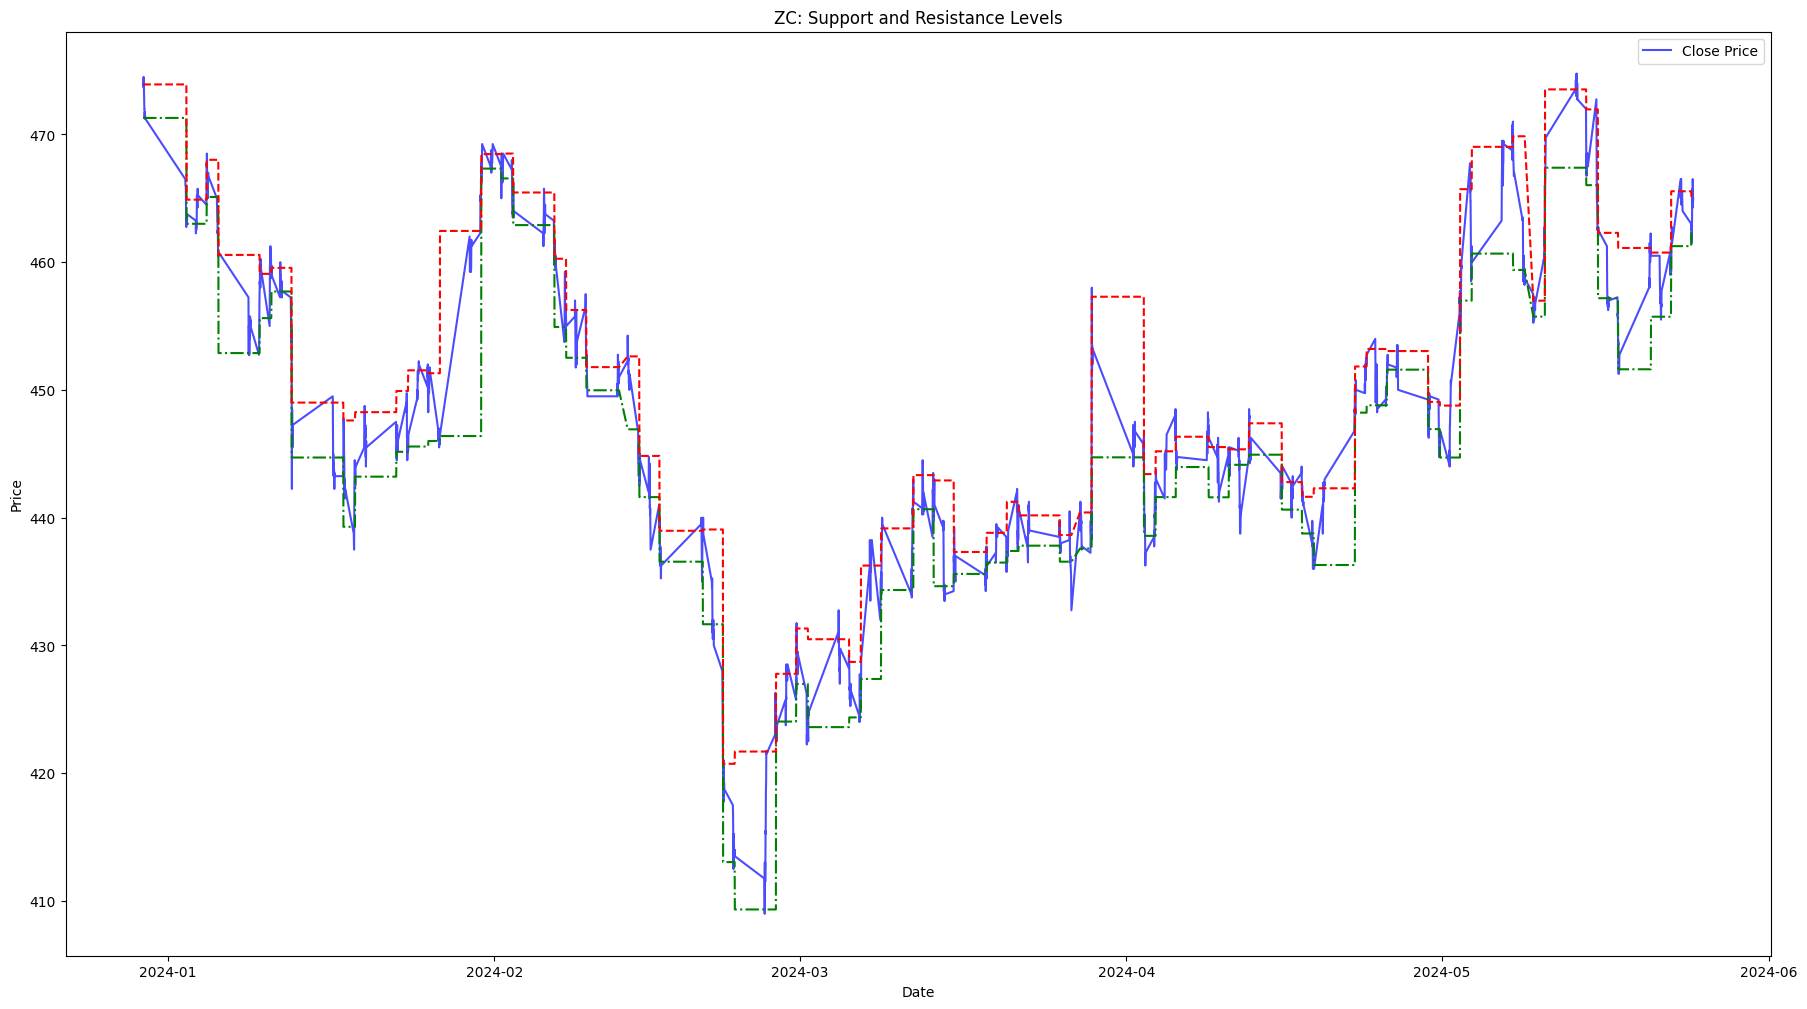

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 12))
plt.plot(sr_df.index, sr_df[f"{TARGET_FUT}_Close"], label='Close Price', color='blue', alpha=0.7)
plt.plot(sr_df.index, sr_df["Support"], linestyle='-.', color='green')
plt.plot(sr_df.index, sr_df["Resistance"], linestyle='--', color='red')

plt.title(f"{TARGET_FUT}: Support and Resistance Levels")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()